## Notebook Tutorial

This page goes through key features and functions supported in the FLUTE tool in an elaborative and interactive manner using notebook.

In [1]:
# Set up package and function imports
import sys,os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src')))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import time
import run_FLUTE

# These three dependencies are for visualization only
import matplotlib.pyplot as plt
import networkx as nx
import altair as alt

In [2]:
# Fill in username and password, as well as the configurations of flute database
db_name = "flute"
db_host = "localhost"
db_user = "root"
db_password = "12345678"

### Using FLUTE to filter interactions

In [3]:
input_file = 'input/example.xlsx'

In [4]:
df = pd.read_excel(input_file)
df = df.fillna('').astype(str)
interaction_df = df[['Regulated Name', 'Regulated ID', 'Regulated Type', 'Regulator Name', 'Regulator ID', 'Regulator Type', 'Paper IDs']]

Let's take a look at all the information we would use from input interactions

In [5]:
interaction_df

,Regulated Name,Regulated ID,Regulated Type,Regulator Name,Regulator ID,Regulator Type,Paper IDs
0,CD4,P01730,Protein,Anti-CD4,UAZ616E74692D434434,Other,PMC7749301
1,CD4,P01730,Protein,anti-CD8 mAbs,UAZ616E74692D434438206D416273,Other,PMC7749301
2,CD8,CD8,Other,rapamycin,5284616,Chemical,PMC7749301
3,acidification,GO:0045851,Biological Process,CD8,CD8,Other,PMC7749301
4,acidification,GO:0045851,Biological Process,transduction,GO:0009293,Biological Process,PMC7749301
...,...,...,...,...,...,...,...
14383,T-cell activation,GO:0042110,Biological Process,CD8,CD8,Other,PMC7214244
14384,calcium,5460341,Chemical,cyclophilin,Cyclophilin,Other,PMC7214244
14385,cytokine production,GO:0001816,Biological Process,CD8,CD8,Other,PMC7214244
14386,transduction,GO:0009293,Biological Process,CAR,P36575,Protein,PMC7214244


Here are regulated and regulator element type breakdown and their top 5 categories

In [6]:
topk_series = interaction_df["Regulated Type"].value_counts().iloc[:5]
topk_df = pd.DataFrame({"Regulated Type":topk_series.index, 'count':topk_series.values})

upper = alt.Chart(topk_df).mark_bar(color="#bae6fd").encode( 
    x = alt.X("count").scale(domain=[0, 7500]),
    y = alt.Y("Regulated Type", sort="-x")
).properties(
    width=500,
    height=200,
    title= "Regulated Element Type Top 5 Categories"
)

topk_series = interaction_df["Regulator Type"].value_counts().iloc[:5]
topk_df = pd.DataFrame({"Regulator Type":topk_series.index, 'count':topk_series.values})

lower = alt.Chart(topk_df).mark_bar(color="#fdd1ba").encode( 
    x = alt.X("count").scale(domain=[0, 7500]),
    y = alt.Y("Regulator Type", sort="-x")
).properties(
    width=500,
    height=200,
    title= "Regulator Element Type Top 5 Categories"
)

alt.vconcat(upper, lower)

alt.VConcatChart(...)

In [7]:
# Make a utility dataframe that include all species
id_name1 = df[['Regulated ID', 'Regulated Name']].rename(
            columns={'Regulated ID': 'ID', 'Regulated Name': 'Name'})
id_name2 = df[['Regulator ID', 'Regulator Name']].rename(
            columns={'Regulator ID': 'ID', 'Regulator Name': 'Name'})
id_name_df = pd.concat([id_name1, id_name2], ignore_index=True)
id_name_df['ID'] = id_name_df['ID'].astype(str).str.slice(0, 50)
id_name_df['Name'] = id_name_df['Name'].astype(str).str.slice(0, 50)
id_name_df = id_name_df.drop_duplicates(subset='ID')

In [8]:
# Ground the utility dataframe to find out stringID information for each species
query = run_FLUTE.Query(db_user, db_password, db_host, db_name)
id_name_df = query.ground_string_id(id_name_df)

This DataFrame contains all the studies species in the input file, listed by their IDs, names, and stringIDs

In [9]:
id_name_df

,ID,Name,stringID
0,P01730,CD4,9606.ENSP00000011653
2,CD8,CD8,NaN
3,GO:0045851,acidification,NaN
5,GO:0016049,cell growth,NaN
6,GO:0009293,transduction,NaN
...,...,...,...
28755,UAZ42434D41784344332062734162,BCMAxCD3 bsAb,NaN
28760,UAZ4D4E442DCE94572064756F434152,MND-ΔW duoCAR,NaN
28766,UAZ64756F434152.t,duoCAR,NaN
28772,Cyclophilin,cyclophilin,NaN


The percentage of species with a valid stringID information is:

In [10]:
len(id_name_df[id_name_df["stringID"].notna()]) / len(id_name_df)

0.21996914260524575

We are interested in interactions that has protein participated either in regulated or regulator element. These interactions are distributed:

In [11]:
both_proteins = (
    (interaction_df['Regulated Type'] == 'Protein') &
    (interaction_df['Regulator Type'] == 'Protein')
)
regulated_protein_only = (
    (interaction_df['Regulated Type'] == 'Protein') &
    (interaction_df['Regulator Type'] != 'Protein')
)
regulator_protein_only = (
    (interaction_df['Regulated Type'] != 'Protein') &
    (interaction_df['Regulator Type'] == 'Protein')
)
neither_protein = (
    (interaction_df['Regulated Type'] != 'Protein') &
    (interaction_df['Regulator Type'] != 'Protein')
)

results = {
    'Both proteins': both_proteins.sum(),
    'Only Regulated is protein': regulated_protein_only.sum(),
    'Only Regulator is protein': regulator_protein_only.sum(),
    'Neither is protein': neither_protein.sum()
}

# Create a dataframe from the results
results_df = pd.DataFrame(list(results.items()), columns=['Category', 'Count'])
alt.Chart(results_df).mark_arc().encode(
    theta="Count",
    color="Category"
)

alt.Chart(...)

In [12]:
# Return interactions that involves a protein:ppis/pcis/pbpis
pt_only_ints = run_FLUTE.filter_protein_ints(interaction_df)
pt_only_ints

,Regulated Name,Regulated ID,Regulator Name,Regulator ID
0,cd4,P01730,anti-cd4,UAZ616E74692D434434
1,cd4,P01730,anti-cd8 mabs,UAZ616E74692D434438206D416273
2,cd4,P01730,cell growth,GO:0016049
3,ifn,Interferon,type,Q13326
4,cell viability,D002470,type,Q13326
...,...,...,...,...
9930,env,P03386,gfp,IPR011584
9931,aes,Q08117,amg,Q99217
9932,bcma,Q02223,april,O75888
9933,dna modification,GO:0006304,car,P36575


In [13]:
# Fill out CIDm information
pt_only_ints = run_FLUTE.get_chem_id(pt_only_ints)
pt_only_ints

,Regulated Name,Regulated ID,Regulator Name,Regulator ID,Regulated CIDm,Regulator CIDm
0,cd4,P01730,anti-cd4,UAZ616E74692D434434,NaN,NaN
1,cd4,P01730,anti-cd8 mabs,UAZ616E74692D434438206D416273,NaN,NaN
2,cd4,P01730,cell growth,GO:0016049,NaN,NaN
3,ifn,Interferon,type,Q13326,NaN,NaN
4,cell viability,D002470,type,Q13326,NaN,NaN
...,...,...,...,...,...,...
9930,env,P03386,gfp,IPR011584,NaN,NaN
9931,aes,Q08117,amg,Q99217,NaN,NaN
9932,bcma,Q02223,april,O75888,NaN,NaN
9933,dna modification,GO:0006304,car,P36575,NaN,NaN


In [14]:
# Fill out GoID information
pt_only_ints = run_FLUTE.get_go_id(pt_only_ints)
pt_only_ints

,Regulated Name,Regulated ID,Regulator Name,Regulator ID,Regulated CIDm,Regulator CIDm,Regulated GoID,Regulator GoID
0,cd4,P01730,anti-cd4,UAZ616E74692D434434,NaN,NaN,NaN,NaN
1,cd4,P01730,anti-cd8 mabs,UAZ616E74692D434438206D416273,NaN,NaN,NaN,NaN
2,cd4,P01730,cell growth,GO:0016049,NaN,NaN,NaN,GO:0016049
3,ifn,Interferon,type,Q13326,NaN,NaN,NaN,NaN
4,cell viability,D002470,type,Q13326,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9930,env,P03386,gfp,IPR011584,NaN,NaN,NaN,NaN
9931,aes,Q08117,amg,Q99217,NaN,NaN,NaN,NaN
9932,bcma,Q02223,april,O75888,NaN,NaN,NaN,NaN
9933,dna modification,GO:0006304,car,P36575,NaN,NaN,GO:0006304,NaN


In [15]:
# Fill out stringID information
pt_only_ints = run_FLUTE.get_string_id(pt_only_ints, id_name_df)
pt_only_ints

,Regulated Name,Regulated ID,Regulator Name,Regulator ID,Regulated CIDm,Regulator CIDm,Regulated GoID,Regulator GoID,Regulated stringID,Regulator stringID
0,cd4,P01730,anti-cd4,UAZ616E74692D434434,NaN,NaN,NaN,NaN,9606.ENSP00000011653,NaN
1,cd4,P01730,anti-cd8 mabs,UAZ616E74692D434438206D416273,NaN,NaN,NaN,NaN,9606.ENSP00000011653,NaN
2,cd4,P01730,cell growth,GO:0016049,NaN,NaN,NaN,GO:0016049,9606.ENSP00000011653,NaN
3,ifn,Interferon,type,Q13326,NaN,NaN,NaN,NaN,NaN,9606.ENSP00000218867
4,cell viability,D002470,type,Q13326,NaN,NaN,NaN,NaN,NaN,9606.ENSP00000218867
...,...,...,...,...,...,...,...,...,...,...
9930,env,P03386,gfp,IPR011584,NaN,NaN,NaN,NaN,NaN,NaN
9931,aes,Q08117,amg,Q99217,NaN,NaN,NaN,NaN,9606.ENSP00000221561,9606.ENSP00000370088
9932,bcma,Q02223,april,O75888,NaN,NaN,NaN,NaN,9606.ENSP00000053243,9606.ENSP00000343505
9933,dna modification,GO:0006304,car,P36575,NaN,NaN,GO:0006304,NaN,NaN,9606.ENSP00000311538


In [16]:
# Fill out UID information
pt_only_ints = run_FLUTE.get_uid(pt_only_ints)
pt_only_ints

,Regulated Name,Regulated ID,Regulator Name,Regulator ID,Regulated CIDm,Regulator CIDm,Regulated GoID,Regulator GoID,Regulated stringID,Regulator stringID,Regulated UID,Regulator UID
0,cd4,P01730,anti-cd4,UAZ616E74692D434434,NaN,NaN,NaN,NaN,9606.ENSP00000011653,NaN,P01730,NaN
1,cd4,P01730,anti-cd8 mabs,UAZ616E74692D434438206D416273,NaN,NaN,NaN,NaN,9606.ENSP00000011653,NaN,P01730,NaN
2,cd4,P01730,cell growth,GO:0016049,NaN,NaN,NaN,GO:0016049,9606.ENSP00000011653,NaN,P01730,NaN
3,ifn,Interferon,type,Q13326,NaN,NaN,NaN,NaN,NaN,9606.ENSP00000218867,NaN,Q13326
4,cell viability,D002470,type,Q13326,NaN,NaN,NaN,NaN,NaN,9606.ENSP00000218867,NaN,Q13326
...,...,...,...,...,...,...,...,...,...,...,...,...
9930,env,P03386,gfp,IPR011584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9931,aes,Q08117,amg,Q99217,NaN,NaN,NaN,NaN,9606.ENSP00000221561,9606.ENSP00000370088,Q08117,Q99217
9932,bcma,Q02223,april,O75888,NaN,NaN,NaN,NaN,9606.ENSP00000053243,9606.ENSP00000343505,Q02223,O75888
9933,dna modification,GO:0006304,car,P36575,NaN,NaN,GO:0006304,NaN,NaN,9606.ENSP00000311538,NaN,P36575


Now input interactions have been narrowed down to contain protein-involved interactions, and each interaction has been populated with information including name/ID/UID/CIDm/GoID/stringID for both regulated and regulator element.

But not all fields are filled out:

In [17]:
# Compute the percentage of null values for each column
null_percentages = pt_only_ints.isnull().mean() * 100
null_percentages_df = null_percentages.reset_index()
null_percentages_df.columns = ['column', 'percentage']

bars = alt.Chart(null_percentages_df).mark_bar(color='#d3effe').encode(
    x=alt.X('column:N', title=''),
    y=alt.Y('percentage:Q', title='Percentage of Null Values'),
    tooltip=['column', 'percentage']
)

# Text labels for the top of the bars
text = bars.mark_text(
    align='center',
    baseline='bottom',
    dy=-5  # Adjust the position of the text
).encode(
    text=alt.Text('percentage:Q', format='.1f')  # Format the text to one decimal place
)

layered_chart = (bars + text).properties(
    width=500,
    height=300,
    title='Percentage of Null Values in pt_only_ints Columns'
).configure_axis(
    labelAngle=315  # Rotate x-axis labels by 45 degrees
)

layered_chart.show()

alt.LayerChart(...)

In [18]:
score_tuple = (0, 0, 0)
pt_scored_ints = query.filter_pt_ints_by_scoring(pt_only_ints, score_tuple)

Using FLUTE tool, you can further filter interactions using the customized score tuple. Here are the scores of these interactions

In [19]:
pt_scored_ints

,Element 1 ID,Element 2 ID,STRING escore,STRING tscore,STRING dscore
0,216239,P08069,180,885,0
1,271,P22001,342,0,0
2,271,P28907,800,163,0
3,784,P04040,690,999,900
4,947,P35548,0,180,0
...,...,...,...,...,...
976,Q9Y5U5,P43489,0,807,0
977,Q9Y5U5,Q07011,0,745,0
978,Q9Y6Q6,P10747,0,152,0
979,UAZ4B693637,Q9NZQ7,0,391,0


In [20]:
score_visual = pt_scored_ints[pt_scored_ints['STRING escore'].str.isnumeric() & pt_scored_ints['STRING tscore'].str.isnumeric() & pt_scored_ints['STRING dscore'].str.isnumeric()]
score_visual[['STRING escore','STRING tscore','STRING dscore']] = score_visual[['STRING escore','STRING tscore','STRING dscore']].apply(pd.to_numeric, errors='coerce', axis=1)

score_visual

,Element 1 ID,Element 2 ID,STRING escore,STRING tscore,STRING dscore
0,216239,P08069,180,885,0
1,271,P22001,342,0,0
2,271,P28907,800,163,0
3,784,P04040,690,999,900
4,947,P35548,0,180,0
...,...,...,...,...,...
976,Q9Y5U5,P43489,0,807,0
977,Q9Y5U5,Q07011,0,745,0
978,Q9Y6Q6,P10747,0,152,0
979,UAZ4B693637,Q9NZQ7,0,391,0


In [21]:
binned_series = score_visual["STRING tscore"].value_counts(bins=20, sort=False)

chart_data_binned = pd.DataFrame({
    "leftbin": binned_series.index.left, 
    "rightbin": binned_series.index.right, 
    "count": binned_series.values
})

chart_data_binned.loc[0, "leftbin"] = score_visual["STRING tscore"].min()

quant_chart = alt.Chart(chart_data_binned).mark_bar(color="#fca5a5").encode(
    x = alt.X("leftbin", bin="binned", title="STRING tscore (binned)"),
    x2 = "rightbin",
    y = alt.Y("count")
).properties(
    width=500,
    height=200,
    title= 'STRING tscore distribution of filtered & scored interactions'
)

quant_chart

alt.Chart(...)

Feel free to query the score specifying Element 1, 2 IDs and ground them back to common names

In [22]:
pt_scored_ints[(pt_scored_ints['Element 1 ID']=='P01730')&(pt_scored_ints['Element 2 ID']=='P10747')]

,Element 1 ID,Element 2 ID,STRING escore,STRING tscore,STRING dscore
212,P01730,P10747,336,590,900


In [23]:
id_name_df[(id_name_df['ID']=='P01730') | (id_name_df['ID']=='P10747') ]

,ID,Name,stringID
0,P01730,CD4,9606.ENSP00000011653
113,P10747,CD28,9606.ENSP00000324890


We finally obtain the filtration result as the output_df

In [24]:
# Map the scored interactions with original input interactions
# And merge the DataFrames based on the sets and drop the helper columns
pt_scored_ints['set_12'] = pt_scored_ints.apply(lambda row: frozenset([row['Element 1 ID'].lower(), row['Element 2 ID'].lower()]), axis=1)
df['set_dr'] = df.apply(lambda row: frozenset([row['Regulated ID'].lower(), row['Regulator ID'].lower()]), axis=1)
output_df = df.merge(pt_scored_ints, left_on='set_dr', right_on='set_12')
output_df = output_df.drop(columns=pt_scored_ints.columns.tolist() + ['set_dr', ])
output_df = output_df.drop_duplicates()
output_df

,Regulator Name,Regulator Type,Regulator Subtype,Regulator HGNC Symbol,Regulator Database,Regulator ID,Regulator Compartment,Regulator Compartment ID,Regulated Name,Regulated Type,...,Mechanism,Site,Cell Line,Cell Type,Tissue Type,Organism,Score,Source,Statements,Paper IDs
0,4-1BB,Protein,,,,Q07011,,,GITR,Protein,...,NONE,,,cl:CL:0000084,,,,,The Cytotoxic cluster was more like Glycolytic...,PMC9939256
1,IL2RA,Protein,,,,P01589,,,GITR,Protein,...,NONE,,,cl:CL:0000084,,,,,The Cytotoxic cluster was more like Glycolytic...,PMC9939256
2,OX40,Protein,,,,P43489,,,GITR,Protein,...,NONE,,,cl:CL:0000084,,,,,The Cytotoxic cluster was more like Glycolytic...,PMC9939256
3,CD28,Protein,,,,P10747,,,IL-2,Protein,...,NONE,,,cl:CL:0000084 ++++ mesh:D018414,,,,,"In contrast , BAFF-R , CD28 , and TACI showed ...",PMC9939256
5,TACI,Protein,,,,O14836,,,IL-2,Protein,...,NONE,,,cl:CL:0000084 ++++ mesh:D018414,,,,,"In contrast , BAFF-R , CD28 , and TACI showed ...",PMC9939256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,PD-L1,Protein,,,,Q9NZQ7,,,TIM-3,Protein,...,NONE,,,mesh:D018414 ++++ cl:CL:0000084 ++++ cl:CL:000...,,,,,"Furthermore , scFv PD-L1 antibody decreased th...",PMC9961031
1582,PD-L1,Protein,,,,Q9NZQ7,,,immune response,Biological Process,...,NONE,,,cl:CL:0000084,,,,,The PD-1 / PD-L1 pathway downregulates anti-tu...,PMC9961031
1584,CAR,Protein,,,,P36575,,,signaling pathway,Biological Process,...,NONE,,,cl:CL:0000235 ++++ cl:CL:0000084 ++++ cl:CL:00...,,,,,A large body of research has revealed that the...,PMC9961031
1585,PD-L1,Protein,,,,Q9NZQ7,,,IL-2,Protein,...,Secretion,,,cl:CL:0000084 ++++ mesh:D018414 ++++ cl:CL:000...,,,,,"After prolonged cancer cell antigen exposure ,...",PMC9961031


The percentage of filtered interactions compared to original input:

In [25]:
len(output_df) / len(df)

0.0778426466499861

You may also visualize some key differences between before and after filtration, e.g., percentage of positive and negative interactions

In [26]:
topk_series = df["Sign"].value_counts().iloc[:2]
total_count = topk_series.sum()
topk_df = pd.DataFrame({"Sign": topk_series.index, 'percentage': (topk_series / total_count) * 100})

# Create the bar chart
upper = alt.Chart(topk_df).mark_bar(color="#bae6fd").encode( 
    x=alt.X("percentage:Q", title="Positive/Negative Percentage Before Filtration"),
    y=alt.Y("Sign:N", sort="-x", title="Sign")
).properties(
    width=500,
    height=100
)

topk_series = output_df["Sign"].value_counts().iloc[:2]
total_count = topk_series.sum()
topk_df = pd.DataFrame({"Sign": topk_series.index, 'percentage': (topk_series / total_count) * 100})

# Create the bar chart
lower = alt.Chart(topk_df).mark_bar(color="#fdd1ba").encode( 
    x=alt.X("percentage:Q", title="Positive/Negative Percentage After Filtration"),
    y=alt.Y("Sign:N", sort="-x", title="Sign")
).properties(
    width=500,
    height=100
)

alt.vconcat(upper, lower)

alt.VConcatChart(...)

These above functions in this section can be summarized into one query.filtered_input_ints(), with input_file, score_tuple as input parameters and output_path (just the path root) as output parameter. Two files are generated, with the time duration to finish this function
- list of reading interactions that pass filtration
- the filtration scores for those filtered interactions

In [27]:
output_path = 'output/example'
score_tuple = (0,0,0)
query.filtered_input_ints(input_file, score_tuple, output_path)

File filtered: input/example.xlsx Time: 42.371906042099 seconds


### Using FLUTE to analyze a paper set

Unzip the large OA file and put it to input/ directory. Load it to year_df for usage. It contains information of published year, PMCID, PMID of million research papers

In [28]:
!unzip ../supplementary/oa_file_list.txt.zip -d "input/"
year_df = run_FLUTE.extract_year("input/oa_file_list.txt")
!rm "input/oa_file_list.txt"
year_df

Archive:  ../supplementary/oa_file_list.txt.zip
  inflating: input/oa_file_list.txt  


,Year,PMCID,PMID
0,2001,PMC13900,PMID:11250746
1,2001,PMC13901,PMID:11250747
2,2001,PMC13902,PMID:11250748
3,2000,PMC13911,PMID:11056684
4,2000,PMC13912,PMID:11400682
...,...,...,...
2811867,2012,PMC7108457,PMID:21978613
2811868,2007,PMC7108459,PMID:17977063
2811870,2020,PMC7108696,PMID:32160537
2811871,2019,PMC7108792,PMID:31640839


In [29]:
topk_series = year_df["Year"].value_counts().iloc[:10]
topk_df = pd.DataFrame({"Year":topk_series.index, 'count':topk_series.values})

cat_chart = alt.Chart(topk_df).mark_bar(color="#bae6fd").encode( 
    x = alt.X("count"),
    y = alt.Y("Year", sort="-x")
).properties(
    width=500,
    height=200,
    title = 'Published Year Distribution of Research Papers in Corpus'
)

cat_chart

alt.Chart(...)

FLUTE offers the function of showing interactions within the same paper set as the input interaction file. Its inclusion of column "Paper IDs" allows such

In [30]:
query = run_FLUTE.Query(db_user, db_password, db_host, db_name)
ints_same_pp = query.get_same_papers_ints(input_file, year_df)
ints_same_pp

array([['9541.XP_005555920.1', '9541.XP_005593605.1', 'activation',
        'PMID018283119'],
       ['9541.XP_005593605.1', '9541.XP_005555920.1', 'activation',
        'PMID018283119'],
       ['10090.ENSMUSP00000029275', '10090.ENSMUSP00000111405',
        'activation', 'PMID018283119'],
       ['10090.ENSMUSP00000111405', '10090.ENSMUSP00000029275',
        'activation', 'PMID018283119']], dtype='<U50')

Our original interaction input was extracted very recently (or from papers without year information), thus there are just a handful of interactions that overlap with them

But we can still view these interactions in the same paper set in a network graph, thanks to networkx package

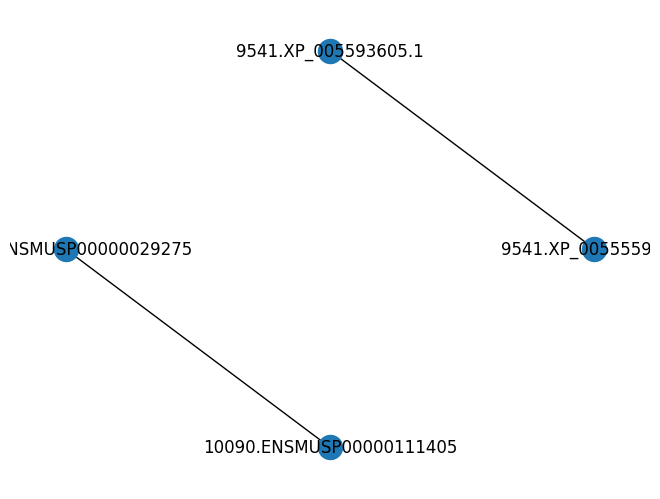

In [31]:
G = nx.from_edgelist(ints_same_pp[:,:2])
nx.draw(G,pos=nx.circular_layout(G),with_labels=True)
plt.show()

### Using FLUTE to query an individual protein

FLUTE also supports the extraction of list of papers that research on certain protein

In [32]:
query_pro = "P00533,P03386"

In [33]:
# get related papers
query = run_FLUTE.Query(db_user, db_password, db_host, db_name)
fq_list = query.get_related_papers(year_df, query_pro)

np.array(fq_list)

array(['PMC1240052', 'PMC1540706', 'PMC1681463', 'PMC1702556',
       'PMC2132490', 'PMC2156182', 'PMC2225448', 'PMC2360392',
       'PMC2575782', 'PMC2742444', 'PMC2756567', 'PMC2824488',
       'PMC3088706', 'PMC3203921', 'PMC3234252', 'PMC3315809',
       'PMC3326441', 'PMC3398014', 'PMC3527276', 'PMC3569983',
       'PMC3730230', 'PMC3767783', 'PMC3952845', 'PMC3965010',
       'PMC4039121', 'PMC4039310', 'PMC4152746', 'PMC4213030',
       'PMC4226707', 'PMC4302072', 'PMC4390223', 'PMC4440518',
       'PMC4615268', 'PMC4724821', 'PMC4741629', 'PMC4791069',
       'PMC4826614', 'PMC5036527', 'PMC5117851', 'PMC5303889',
       'PMC5342422', 'PMC5432325', 'PMC5449203', 'PMC5461031',
       'PMC5531611', 'PMC5641085', 'PMC5648601', 'PMC5715073',
       'PMC5817799', 'PMC5935102', 'PMC5977112', 'PMC5992104',
       'PMC6053247', 'PMC6365915'], dtype='<U10')

Use the function discussed above, interactions inside these papers can be extracted, these interactions co-occur with the inquired protein in the same literature and are of great research interest

In [34]:
pd.DataFrame(fq_list, columns=['Paper IDs']).to_excel(output_path + '_query_' + query_pro + '.xlsx', index=False)
related_pp = query.get_same_papers_ints(output_path + '_query_' + query_pro + '.xlsx', year_df)

print("Number of interactions inside related_pp: ", len(related_pp))
related_pp[:15]

Number of interactions inside related_pp:  78


array([['7227.FBpp0084623', '7227.FBpp0084626', 'binding',
        'PMID028515276'],
       ['7227.FBpp0084626', '7227.FBpp0084623', 'binding',
        'PMID028515276'],
       ['7227.FBpp0084626', '7227.FBpp0305095', 'binding',
        'PMID028515276'],
       ['7227.FBpp0305095', '7227.FBpp0084626', 'binding',
        'PMID028515276'],
       ['8364.ENSXETP00000021098', '8364.ENSXETP00000061006', 'binding',
        'PMID026344197'],
       ['8364.ENSXETP00000061006', '8364.ENSXETP00000021098', 'binding',
        'PMID026344197'],
       ['9606.ENSP00000175756', '9606.ENSP00000269571', 'ptmod',
        'PMID025081058'],
       ['9606.ENSP00000219070', '9606.ENSP00000301178', 'expression',
        'PMID027775700'],
       ['9606.ENSP00000261739', '9606.ENSP00000275493', 'binding',
        'PMID022298428'],
       ['9606.ENSP00000269571', '9606.ENSP00000175756', 'ptmod',
        'PMID025081058'],
       ['9606.ENSP00000275493', '9606.ENSP00000261739', 'binding',
        'PMID022298428']

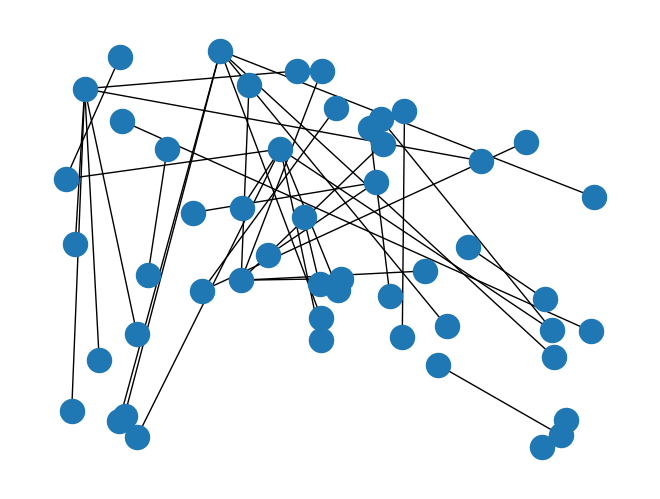

In [35]:
# View these interactions in a networkx graph
G = nx.from_edgelist(related_pp[:,:2])
nx.draw(G,pos=nx.random_layout(G),with_labels=False)
plt.show()

### Using FLUTE to find recent interactions

In [36]:
# Map the input interaction file with its paper published year
df = pd.read_excel(input_file)
df = df.merge(year_df, left_on='Paper IDs', right_on='PMCID')
df['Year']=df['Year'].astype('int64')
df

,Regulator Name,Regulator Type,Regulator Subtype,Regulator HGNC Symbol,Regulator Database,Regulator ID,Regulator Compartment,Regulator Compartment ID,Regulated Name,Regulated Type,...,Cell Type,Tissue Type,Organism,Score,Source,Statements,Paper IDs,Year,PMCID,PMID
0,CAR,Protein,NaN,NaN,NaN,P36575,NaN,NaN,tumor,Biological Process,...,cl:CL:0000084,NaN,uberon:UBERON:0002015,NaN,NaN,Anti-CAIX CAR T cells secreting anti-PD-L1 ant...,PMC5085160,2016,PMC5085160,PMID:27145284
1,CAR,Protein,NaN,NaN,NaN,P36575,NaN,NaN,ADCC,Biological Process,...,cl:CL:0000084 ++++ cl:CL:0001063,NaN,NaN,NaN,NaN,"Moreover , anti-CAIX CAR T cells secreting the...",PMC5085160,2016,PMC5085160,PMID:27145284
2,IgG1 isoform,Other,NaN,NaN,NaN,UAZ496747312069736F666F726D,NaN,NaN,ADCC,Biological Process,...,cl:CL:0000084 ++++ cl:CL:0000623,NaN,NaN,NaN,NaN,For the anti-CAIX CAR T cells secreting anti-P...,PMC5085160,2016,PMC5085160,PMID:27145284
3,CAR,Protein,NaN,NaN,NaN,P36575,NaN,NaN,CAIX,Protein,...,cl:CL:0000084 ++++ cl:CL:0000623,NaN,NaN,NaN,NaN,The anti-CAIX CAR T cells only produced IL-2 a...,PMC5085160,2016,PMC5085160,PMID:27145284
4,CAIX,Protein,NaN,NaN,NaN,Q16790,NaN,NaN,CAR,Protein,...,cl:CL:0000084 ++++ cl:CL:0000623,NaN,NaN,NaN,NaN,The anti-CAIX CAR T cells only produced IL-2 a...,PMC5085160,2016,PMC5085160,PMID:27145284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,CD4,Protein,NaN,NaN,NaN,P01730,NaN,NaN,IL7,Protein,...,cl:CL:0000084,NaN,NaN,NaN,NaN,The percentage of CD4 CARGD2.28.OX40 ζ T cells...,PMC5980417,2018,PMC5980417,PMID:29872565
3113,ζ,Other,NaN,NaN,NaN,UAZCEB6,NaN,NaN,IL7,Protein,...,cl:CL:0000084,NaN,NaN,NaN,NaN,The percentage of CD4 CARGD2.28.OX40 ζ T cells...,PMC5980417,2018,PMC5980417,PMID:29872565
3114,CAR.GD2,Other,NaN,NaN,NaN,UAZ4341522E474432,NaN,NaN,proliferation,Biological Process,...,cl:CL:0000084 ++++ cl:CL:0000034 ++++ cl:CL:00...,NaN,NaN,NaN,NaN,These cytokines are known to enhance survival ...,PMC5980417,2018,PMC5980417,PMID:29872565
3115,ζ,Other,NaN,NaN,NaN,UAZCEB6,NaN,NaN,IL2,Protein,...,cl:CL:0000084 ++++ cl:CL:0000034 ++++ cl:CL:00...,NaN,NaN,NaN,NaN,"After exposure to GD2 tumor cells , a higher q...",PMC5980417,2018,PMC5980417,PMID:29872565


In [37]:
binned_series = df["Year"].value_counts(bins=12, sort=False)

chart_data_binned = pd.DataFrame({
    "leftbin": binned_series.index.left, 
    "rightbin": binned_series.index.right, 
    "count": binned_series.values
})

chart_data_binned.loc[0, "leftbin"] = df["Year"].min()

quant_chart = alt.Chart(chart_data_binned).mark_bar(color="#fca5a5").encode(
    x = alt.X("leftbin", bin="binned", title="Year (binned)"),
    x2 = "rightbin",
    y = alt.Y("count")
).properties(
    width=500,
    height=200,
    title = 'Published Year Distribution of All Input Interactions (Unknown Removed)'
    
)

quant_chart

alt.Chart(...)

In [38]:
# Define a number of years
x = 5  # recent 5 years
df = df[df['Year'] >= time.localtime().tm_year - x].drop(columns=year_df.columns)

This DataFrame only contains recent (less than 5 years) interactions published at a known year. The number shrinks a lot compared to original input interaction file

This is useful if users want to exempt these interactions from filtering

In [39]:
df

,Regulator Name,Regulator Type,Regulator Subtype,Regulator HGNC Symbol,Regulator Database,Regulator ID,Regulator Compartment,Regulator Compartment ID,Regulated Name,Regulated Type,...,Mechanism,Site,Cell Line,Cell Type,Tissue Type,Organism,Score,Source,Statements,Paper IDs
13,UniCAR,Other,NaN,NaN,NaN,UAZ556E69434152,NaN,NaN,4-1BB,Protein,...,NONE,NaN,NaN,cl:CL:0000815 ++++ cl:CL:0001063,NaN,NaN,NaN,NaN,"As shown in Figure 4 ( a ) ( middle panel ) , ...",PMC6685520
14,TCR-,Other,NaN,NaN,NaN,TCR,NaN,NaN,proliferation,Biological Process,...,NONE,NaN,NaN,cl:CL:0000815,NaN,NaN,NaN,NaN,To further support the aforementioned findings...,PMC6685520
15,luciferase,Protein,NaN,NaN,NaN,Q01158,NaN,NaN,tumor,Biological Process,...,NONE,NaN,NaN,cl:CL:0000815 ++++ cl:CL:0001063,NaN,NaN,NaN,NaN,In mice transplanted with UniCAR endowed Tconv...,PMC6685520
16,UniCAR,Other,NaN,NaN,NaN,UAZ556E69434152,Other,sl-0487,CD4 CD25 CD127,Other,...,NONE,NaN,NaN,cl:CL:0000084 ++++ cl:CL:0000815,NaN,NaN,NaN,NaN,To investigate responsiveness of UniCAR armed ...,PMC6685520
17,CD3,Other,NaN,NaN,NaN,CD3,NaN,NaN,T cell activation,Biological Process,...,NONE,NaN,NaN,cl:CL:0000084 ++++ cl:CL:0000236,NaN,NaN,NaN,NaN,"Originally , first generation CARs were design...",PMC6685520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3085,mAb,Other,NaN,NaN,NaN,UAZ6D4162,Other,sl-0431,SHP-2,Protein,...,Phosphorylation,NaN,NaN,cl:CL:0000235 ++++ cl:CL:0000236 ++++ cl:CL:00...,NaN,NaN,NaN,NaN,"Functionally , mAb targeting PD-L1 was able to...",PMC6558778
3086,PD-1,Protein,NaN,NaN,NaN,P18621.t,NaN,NaN,PD-L1,Protein,...,Transcription,NaN,cellosaurus:CVCL_1905,mesh:D015496 ++++ cl:CL:0000623 ++++ mesh:D018...,NaN,NaN,NaN,NaN,"Furthermore , lenalidomide , an immunomodulato...",PMC6558778
3087,PD-L1,Protein,NaN,NaN,NaN,Q9NZQ7,Other,sl-0431,SHP-2,Protein,...,Phosphorylation,NaN,NaN,cl:CL:0000235 ++++ cl:CL:0000236 ++++ cl:CL:00...,NaN,NaN,NaN,NaN,"Functionally , mAb targeting PD-L1 was able to...",PMC6558778
3088,mAb,Other,NaN,NaN,NaN,UAZ6D4162,Other,sl-0431,SHP-2,Protein,...,Phosphorylation,NaN,NaN,cl:CL:0000235 ++++ cl:CL:0000236 ++++ cl:CL:00...,NaN,NaN,NaN,NaN,"Functionally , mAb targeting PD-L1 was able to...",PMC6558778


### Using FLUTE to find duplicate interactions

In [40]:
df = pd.read_excel(input_file)

columns_to_check = ['Regulated ID', 'Regulator ID', 'Paper IDs']
duplicates = df[df.duplicated(subset=columns_to_check, keep=False)]
duplicate_counts = duplicates.groupby(columns_to_check).size().reset_index(name='Occurrence')

This DataFrame contains the duplicated interactions (based on Regulated ID, Regulator ID, Paper IDs) of the original input file and their occurrences.

This is helpful when user wants to only keep unique interactions

In [41]:
duplicate_counts.sort_values(by='Occurrence', ascending=False)

,Regulated ID,Regulator ID,Paper IDs,Occurrence
462,Q9NZQ7,Q9NZQ7.t,PMC10098269,8
278,P18621,P31947,PMC8614004,5
319,P29597,P18031,PMC8904293,5
209,P01375,P05231.s,PMC8018404,4
458,Q9NZQ7,P31947,PMC8614004,4
...,...,...,...,...
175,Interferon,P36575,PMC6174845,2
174,Interferon,P01730,PMC3654581,2
173,Interferon,CD8,PMC3654581,2
172,IPR011584,P36575:[SubstitutionMutant],PMC9853244,2


In [42]:
topk_series = duplicate_counts["Regulated ID"].value_counts().iloc[:5]
total_count = len(duplicate_counts)
topk_df = pd.DataFrame({"Regulated ID": topk_series.index, 'percentage': (topk_series / total_count) * 100})

# Create the bar chart
upper = alt.Chart(topk_df).mark_bar(color="#bae6fd").encode( 
    x=alt.X("percentage", title="Percentage of Top 5 Repeated Regulated IDs"),
    y=alt.Y("Regulated ID:N", sort="-x", title="")
).properties(
    width=500,
    height=200
)

topk_series = duplicate_counts["Regulator ID"].value_counts().iloc[:5]
total_count = len(duplicate_counts)
topk_df = pd.DataFrame({"Regulator ID": topk_series.index, 'percentage': (topk_series / total_count) * 100})

# Create the bar chart
lower = alt.Chart(topk_df).mark_bar(color="#fdd1ba").encode( 
    x=alt.X("percentage", title="Percentage of Top 5 Repeated Regulator IDs").scale(domain=[0, 12]),
    y=alt.Y("Regulator ID:N", sort="-x", title="")
).properties(
    width=500,
    height=200
)

alt.vconcat(upper, lower)

alt.VConcatChart(...)